In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import requests
import math


def load_champions(api_key):        
    req = 'https://euw1.api.riotgames.com/lol/static-data/v3/champions?api_key=' + api_key + '&dataById=true'
    resp = requests.get(req)
    return resp.json()['data']


def load_summoner_spells(api_key):
    req = 'https://euw1.api.riotgames.com/lol/static-data/v3/summoner-spells?api_key=' + api_key + '&dataById=true'
    resp = requests.get(req)
    return resp.json()['data']


def load_objects(path):
    objects = []
    with (open(path, "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break
    return objects

def save_object(object, path):
    with open(path, 'wb') as f:
        pickle.dump(object, f, pickle.HIGHEST_PROTOCOL)
    
    
def highest_achieved_season_tiers_from_match(match):
    participants = match['participants']
    return [ participant['highestAchievedSeasonTier'] for participant in participants if 'highestAchievedSeasonTier' in participant ]


def patch_from_match(match):
    versions = match['gameVersion'].split('.')
    return versions[0] + '.' + versions[1]

In [2]:
games = load_objects('data/matches.pkl')[0]

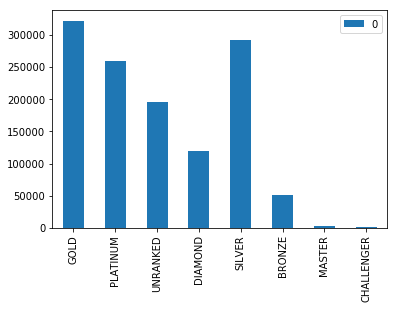

0
GOLD        322126
PLATINUM    259412
UNRANKED    195672
DIAMOND     119309
SILVER      292704
BRONZE       51144
MASTER        2394
CHALLENGER     679

In [3]:
leagues = []
for _, details in games.items():
    leagues.extend(highest_achieved_season_tiers_from_match(details))
    
leagues_counter = Counter(leagues)
df = pd.DataFrame.from_dict(leagues_counter, orient='index')
df.plot.bar()
plt.show()
df

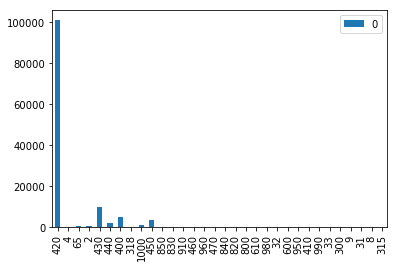

In [4]:
qeues = [ details['queueId'] for _, details in games.items() ]
qeues_counter = Counter(qeues)
df = pd.DataFrame.from_dict(qeues_counter, orient='index')
df.plot.bar()
plt.show()

In [5]:
games_list = list(games.values())
ranked_solo_queue_games = [ game for game in games_list if game['queueId'] == 420 ]
len(ranked_solo_queue_games)

101014

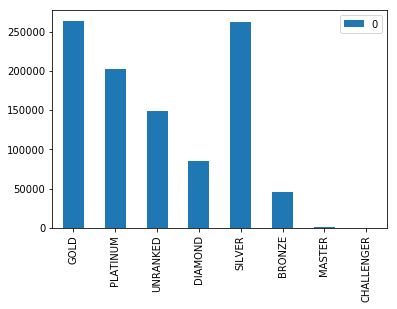

0
GOLD        263944
PLATINUM    203143
UNRANKED    148685
DIAMOND      85485
SILVER      261860
BRONZE       45587
MASTER        1287
CHALLENGER     149

In [6]:
leagues = []
for details in ranked_solo_queue_games:
    leagues.extend(highest_achieved_season_tiers_from_match(details))
    
leagues_counter = Counter(leagues)
df = pd.DataFrame.from_dict(leagues_counter, orient='index')
df.plot.bar()
plt.show()
df

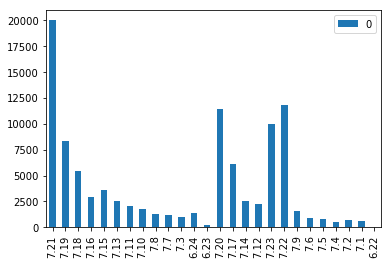

0
7.21  19960
7.19   8325
7.18   5458
7.16   2912
7.15   3580
7.13   2548
7.11   2067
7.10   1787
7.8    1323
7.7    1175
7.3     978
6.24   1425
6.23    186
7.20  11411
7.17   6111
7.14   2567
7.12   2290
7.23   9968
7.22  11760
7.9    1605
7.6     887
7.5     783
7.4     544
7.2     739
7.1     614
6.22     11

In [7]:
patches = []
for details in ranked_solo_queue_games:
    patch = patch_from_match(details)
    patches.append(patch)
    
patches_counter = Counter(patches)
df = pd.DataFrame.from_dict(patches_counter, orient='index')
df.plot.bar()
plt.show()
df

In [8]:
champions = load_champions('RGAPI-b9d297aa-097d-410a-a492-cfe6f0c41703')
champion_ids = list(champions.keys())
champion_ids.sort()
champion_ids

champ_to_int = {}
int_to_champ = {}
i = 0
for champion_id in champion_ids:
    champ_to_int[champion_id] = i
    int_to_champ[i] = champion_id
    i += 1

In [9]:
summoner_spells = load_summoner_spells('RGAPI-b9d297aa-097d-410a-a492-cfe6f0c41703')

In [10]:
summoner_spell_ids = list(summoner_spells.keys())
summoner_spell_ids.sort()
summoner_spell_ids

summoner_spell_to_int = {}
int_to_summoner_spell = {}
i = 0
for summoner_spell_id in summoner_spell_ids:
    summoner_spell_to_int[summoner_spell_id] = i
    int_to_summoner_spell[i] = summoner_spell_id
    i += 1

In [11]:
ranks = ['UNRANKED', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND', 'MASTER', 'CHALLENGER']
rank_to_int = {}
int_to_rank = {}
i = 0
for rank in ranks:
    rank_to_int[rank] = i 
    int_to_rank[i] = rank
    i += 1

In [12]:
def filter_data(matches, queue, patch):
    return [ match for match in matches if match['queueId'] == queue and patch_from_match(match) in patch ] 
    
filtered_matches = filter_data(games_list, 420, ['7.19', '7.20', '7.21'])
len(filtered_matches)

39696

In [13]:
def team_win_to_int(team):
    if team['win'] == 'Win':
        return 1
    return 0


def transformation_header():
    header = []
    header.extend(['blue_side_won', 'red_side_won'])
    
    for side in ['blue', 'red']:
        for position in ['top', 'jungle', 'mid', 'adc', 'support']:
            prefix = side + '_' + position + '_'
            
            # champion
            for i in range(len(champions)):
                champion = champions[int_to_champ[i]]
                header.append(prefix + champion['name'].lower())
            
            # rank
            for i in range(len(ranks)):
                rank = int_to_rank[i]
                header.append(prefix + rank.lower())
            
            # spell 1
            for i in range(len(summoner_spells)):
                spell = summoner_spells[int_to_summoner_spell[i]]
                header.append(prefix + 'spell1_' + spell['key'].lower())
            
            # spell 2
            for i in range(len(summoner_spells)):
                spell = summoner_spells[int_to_summoner_spell[i]]
                header.append(prefix + 'spell2_' + spell['key'].lower())
    
    return header


def participant_summary(participant):
    return { 'champ_id': participant['championId'], 
            'rank': participant['highestAchievedSeasonTier'], 
            'spell1_id': participant['spell1Id'], 
            'spell2_id': participant['spell2Id'] }


def players_from_participants(participants):
    result = { 'top': None, 'jungle': None, 'mid': None, 'adc': None, 'support': None }
    for p in participants:
        timeline = p['timeline']
        
        # top
        if timeline['lane'] == 'TOP' and timeline['role'] == 'SOLO':
            result['top'] = participant_summary(p)
            
        # jungle
        if timeline['lane'] == 'JUNGLE':
            result['jungle'] = participant_summary(p)
            
        # mid
        if timeline['lane'] == 'MIDDLE' and timeline['role'] == 'SOLO':
            result['mid'] = participant_summary(p)
            
        # adc
        if timeline['lane'] == 'BOTTOM' and timeline['role'] == 'DUO_CARRY':
            result['adc'] = participant_summary(p)
            
        # support
        if timeline['lane'] == 'BOTTOM' and timeline['role'] == 'DUO_SUPPORT':
            result['support'] = participant_summary(p)
    
    return result
        

def transform_player_summary(player):
    result = []
    
    # champion
    champion = list(np.zeros(len(champ_to_int)))
    champion[ champ_to_int[str(player['champ_id'])] ] = 1
    result.extend(champion)
    
    # rank
    rank = list(np.zeros(len(rank_to_int)))
    rank[ rank_to_int[player['rank']] ] = 1
    result.extend(rank)
    
    # spell 1
    spell = list(np.zeros(len(summoner_spell_to_int)))
    spell[ summoner_spell_to_int[str(player['spell1_id'])] ] = 1
    result.extend(spell)
    
    # spell 2
    spell = list(np.zeros(len(summoner_spell_to_int)))
    spell[ summoner_spell_to_int[str(player['spell2_id'])] ] = 1
    result.extend(spell)
    
    return result
    

def transform_match(match):
    result = []
    
    # WINNER
    blue_side_won = 0
    red_side_won = 0
    for team in match['teams']:
        if team['teamId'] == 100: 
            # Blue side
            blue_side_won = team_win_to_int(team)
        else: 
            # Red side
            red_side_won = team_win_to_int(team)
    
    result.extend([blue_side_won, red_side_won])
    
    blue_team_participants = [ participant for participant in match['participants'] if participant['teamId'] == 100 ]
    red_team_participants = [ participant for participant in match['participants'] if participant['teamId'] == 200 ]
    
    blue_player_summary = players_from_participants(blue_team_participants)
    red_player_summary = players_from_participants(red_team_participants)
    if None in blue_player_summary.values() or None in red_player_summary.values():
        return None
    
    # blue team
    result.extend(transform_player_summary(blue_player_summary['top']))
    result.extend(transform_player_summary(blue_player_summary['jungle']))
    result.extend(transform_player_summary(blue_player_summary['mid']))
    result.extend(transform_player_summary(blue_player_summary['adc']))
    result.extend(transform_player_summary(blue_player_summary['support']))
    
    # red team
    result.extend(transform_player_summary(red_player_summary['top']))
    result.extend(transform_player_summary(red_player_summary['jungle']))
    result.extend(transform_player_summary(red_player_summary['mid']))
    result.extend(transform_player_summary(red_player_summary['adc']))
    result.extend(transform_player_summary(red_player_summary['support']))
    
    return result

    
transformed_matches = [ transform_match(match) for match in filtered_matches ]
transformed_matches = [ transformed_match for transformed_match in transformed_matches if transformed_match is not None ]
print(len(transformed_matches))
#save_object(transformed_matches, 'transformed.pkl')

32677


In [14]:
np.random.shuffle(transformed_matches)

In [15]:
train_proportion = 0.7
valid_proportion = 0.15
test_proportion  = 0.15 

In [16]:
n_matches = len(transformed_matches)
print(n_matches)

train_size = math.ceil(n_matches * train_proportion)
valid_size = math.ceil(n_matches * valid_proportion)

train_data = transformed_matches[0:train_size]
valid_data = transformed_matches[train_size+1:train_size+valid_size]
test_data = transformed_matches[train_size+valid_size+1:]

32677


In [17]:
def split_data(data): 
    df = pd.DataFrame(data)
    return df[df.columns[2:]].values, df[[0,1]].values


train_features, train_labels = split_data(train_data)
save_object(train_features, 'transformed/train_features.pkl')
save_object(train_labels, 'transformed/train_labels.pkl')

valid_features, valid_labels = split_data(valid_data)
save_object(valid_features, 'transformed/valid_features.pkl')
save_object(valid_labels, 'transformed/valid_labels.pkl')

test_features, test_labels = split_data(test_data)
save_object(test_features, 'transformed/test_features.pkl')
save_object(test_labels, 'transformed/test_labels.pkl')

In [18]:
train_features.shape

(22874, 1850)